In [1]:
"""
File: XGBoost.ipynb
Code to train and evaluate an XGBoost model on MIMIC-IV FHIR dataset.
"""


def Project():
    """
    __Objectives__
    0. Import data and separate unique visit tokens
    1. Reduce the number of features (manual selection, hierarchy aggregation)
    2. Create frequency features from event tokens
    3. Include num_visits, youngest and oldest age, and maybe time
    4. Use label column to create the prediction objective
    5. Train XGBoost model and evaluate on test dataset

    __Questions__
    0. Why does CEHR-BERT only have 512 possible concept and time tokens? -> Probably most tokens are not present in the sample

    __Extra__
    Hyperparameters: {learning rate (LR), maximum tree depth (max depth), number of estimators (n estimators),
                      column sampling by tree (colsample), row subsampling (subsample) and the regulation parameter α.}
    """
    return ProjectObjectives.__doc__

In [2]:
import os

ROOT = "/fs01/home/afallah/odyssey/odyssey"
os.chdir(ROOT)
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import (
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
)
from scipy.sparse import csr_matrix, hstack, vstack, save_npz, load_npz

from tqdm import tqdm

%matplotlib inline

DATA_ROOT = f"{ROOT}/data"
DATA_PATH = f"{DATA_ROOT}/slurm_data/one_month/pretrain.parquet"
FINE_TUNE_PATH = f"{DATA_ROOT}/slurm_data/one_month/fine_tune.parquet"
TEST_DATA_PATH = f"{DATA_ROOT}/slurm_data/one_month/fine_test.parquet"
FREQ_MATRIX_PATH = f"{DATA_ROOT}/slurm_data/one_month/patient_freq_matrix.npz"

In [77]:
list(set(data['length']))[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [3]:
# Load data
pretrain_data = pd.read_parquet(DATA_PATH)
pretrain_data = pretrain_data[pretrain_data['event_tokens_2048'].notnull()]
pretrain_data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_2048,type_tokens_2048,age_tokens_2048,time_tokens_2048,visit_tokens_2048,position_tokens_2048,label
0,f8f3289a-057f-5fcc-a714-5f6109ca16c4,2,0,NaN,NaN,1,4,"[[CLS], [VS], 8938, [VE], [PAD], [PAD], [PAD],...","[1, 2, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 18, 18, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 8262, 8262, 8262, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 2049, 2049, 2049, 2049, 2049, 204...",0
1,9b62c9f4-3fdc-5020-82b5-ae5b8292445a,4,0,NaN,NaN,43,52,"[[CLS], [VS], 7569, 66689036430, 00904224461, ...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, ...","[0, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28...","[0, 5963, 5963, 5963, 5963, 5963, 5963, 5963, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
2,2ca522eb-dd89-5f79-8155-9599ea46b0b2,2,1,244.0,242.0,51,54,"[[CLS], [VS], 00904629261, 00904642281, 009046...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86...","[0, 8016, 8016, 8016, 8016, 8016, 8016, 8016, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
4,02adf8a6-8bc0-55d3-81ae-4d8582094896,9,1,20.0,11.0,640,664,"[[CLS], [VS], 51079045420, 00006494300, 177140...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, ...","[0, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65...","[0, 8002, 8002, 8002, 8002, 8002, 8002, 8002, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
5,744fe3c4-9b03-55ae-ac9f-6bc4e967cde7,3,0,NaN,NaN,80,86,"[[CLS], [VS], 7813, 7813, 7902, 7902, 9604, 00...","[1, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29...","[0, 7582, 7582, 7582, 7582, 7582, 7582, 7582, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173666,cf2115d7-937e-511d-b159-dd7eb3d5d420,3,0,NaN,NaN,166,172,"[[CLS], [VS], 66591018442, 63323026201, 001350...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32...","[0, 5481, 5481, 5481, 5481, 5481, 5481, 5481, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
173667,31338a39-28f9-54a5-a810-2d05fbaa5166,4,0,NaN,NaN,283,292,"[[CLS], [VS], 5014, 5123, 00338011704, 6332302...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50...","[0, 4997, 4997, 4997, 4997, 4997, 4997, 4997, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
173668,0989415d-394c-5f42-8dac-75dc7306a23c,3,0,NaN,NaN,470,476,"[[CLS], [VS], 51079043620, 51079088120, 492810...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 3, 4, 2, 7, 7, 7, ...","[0, 52, 52, 52, 52, 52, 52, 52, 52, 52, 0, 52,...","[0, 5309, 5309, 5309, 5309, 5309, 5309, 5309, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...",0
173669,26fb8fef-b976-5c55-859d-cc190261f94b,3,0,NaN,NaN,93,99,"[[CLS], [VS], 0SRD0J9, 60505251903, 0090422446...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61...","[0, 5085, 5085, 5085, 5085, 5085, 5085, 5085, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0


In [4]:
# Load data
finetune_data = pd.read_parquet(FINE_TUNE_PATH)
finetune_data = finetune_data[finetune_data['event_tokens_2048'].notnull()]
finetune_data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_2048,type_tokens_2048,age_tokens_2048,time_tokens_2048,visit_tokens_2048,position_tokens_2048,label
143942,f75b650a-8f74-5f99-94ec-47bc407f9a9c,4,0,NaN,NaN,112,121,"[[CLS], [VS], 00172436560, 00904224461, 001724...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, ...","[0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30...","[0, 6015, 6015, 6015, 6015, 6015, 6015, 6015, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
3127,25535c90-9aa8-58cb-af41-990f22d6c813,4,1,6.0,5.0,645,654,"[[CLS], [VS], 0DTF0ZZ, 0WPF0JZ, 0W9G00Z, 0DU90...","[1, 2, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, ...","[0, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58...","[0, 6737, 6737, 6737, 6737, 6737, 6737, 6737, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
63953,f7faf8eb-dcc0-539c-8230-ab7b4e0a21c8,9,1,12.0,6.0,881,905,"[[CLS], [VS], 7749, 8166, 00009454101, 0007803...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86...","[0, 7705, 7705, 7705, 7705, 7705, 7705, 7705, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
157648,5ee994a2-6b36-5dc7-9e37-bf80011b6e1e,2,0,NaN,NaN,16,19,"[[CLS], [VS], 51079028620, 00093435693, 510790...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18...","[0, 5158, 5158, 5158, 5158, 5158, 5158, 5158, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
61712,de7540cb-8b9a-5fb0-ad40-36b2784a8edf,2,1,1.0,0.0,24,27,"[[CLS], [VS], 5A1935Z, 63323061401, 0033800490...","[1, 2, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63...","[0, 8605, 8605, 8605, 8605, 8605, 8605, 8605, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22291,052ca40b-d12e-5390-a9f1-70a6edbfa162,2,1,63.0,24.0,1879,1882,"[[CLS], [VS], 5A1955Z, 0B9B8ZX, 3E0G76Z, 02100...","[1, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89...","[0, 6083, 6083, 6083, 6083, 6083, 6083, 6083, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
147301,7cdb1fd3-eb2c-52d3-bfd1-9bbd38db8e72,3,1,44.0,0.0,2046,2052,"[[CLS], [VS], 00904150061, 00363069338, 001828...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, ...","[0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76...","[0, 8293, 8293, 8293, 8293, 8293, 8293, 8293, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",1
30477,f2352e22-fa5b-5d10-a285-6109282afb6c,20,1,27.0,25.0,1836,1893,"[[CLS], [VS], 3950, 3895, 0040, 3995, 3949, 00...","[1, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 3, ...","[0, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75...","[0, 4876, 4876, 4876, 4876, 4876, 4876, 4876, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
28930,472730fd-189f-524c-a649-1f9d184e80c7,6,1,2.0,0.0,1090,1105,"[[CLS], [VS], 00904516561, 57896042101, 764390...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79...","[0, 6498, 6498, 6498, 6498, 6498, 6498, 6498, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1


In [5]:
# Load data
test_data = pd.read_parquet(TEST_DATA_PATH)
test_data = test_data[test_data['event_tokens_2048'].notnull()]
test_length = len(test_data)
test_data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_2048,type_tokens_2048,age_tokens_2048,time_tokens_2048,visit_tokens_2048,position_tokens_2048,label
21185,a8f4e876-b5a0-5f59-b6dc-e842d95bcfe5,7,1,24.0,17.0,613,631,"[[CLS], [VS], 00054853516, 00245008201, 003380...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70...","[0, 5050, 5050, 5050, 5050, 5050, 5050, 5050, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
16720,d6425657-47fa-57da-adda-db1af92ad0f8,3,0,NaN,NaN,202,208,"[[CLS], [VS], 54569105100, 49281041688, 633230...","[1, 2, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, ...","[0, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26...","[0, 5483, 5483, 5483, 5483, 5483, 5483, 5483, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
117588,cffad8a4-3014-5fae-85eb-fb8f9adc9d91,2,1,6.0,0.0,424,427,"[[CLS], [VS], 966, 022, 9672, 9604, 3891, 0131...","[1, 2, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, ...","[0, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81...","[0, 8384, 8384, 8384, 8384, 8384, 8384, 8384, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
117814,4fffaae4-0d88-5d33-bacc-45fe99bc7d7d,10,1,6.0,0.0,1878,1905,"[[CLS], [VS], 0015, 3893, 00472500360, 0040967...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65...","[0, 6869, 6869, 6869, 6869, 6869, 6869, 6869, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
73537,97c12d45-83aa-5d1d-9eb3-b4ccd18c1945,3,0,NaN,NaN,40,46,"[[CLS], [VS], 00406831562, 00409198530, 195150...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, ...","[0, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45...","[0, 7476, 7476, 7476, 7476, 7476, 7476, 7476, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49007,eb604179-70ba-57d3-b946-9594f2bce625,41,1,58.0,0.0,9189,9309,"[[CLS], [VS], 51221_0, 51006_0, 50983_4, 50971...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55...","[0, 9940, 9940, 9940, 9940, 9940, 9940, 9940, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41...",1
38305,4e2eeebd-d378-5d90-8c11-127e835fd727,2,1,8.0,0.0,629,632,"[[CLS], [VS], 5491, 5101, 9672, 9604, 3897, 33...","[1, 2, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, ...","[0, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68...","[0, 5430, 5430, 5430, 5430, 5430, 5430, 5430, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
61522,81a61c04-3dfa-5291-b686-b5597b0acf78,2,1,4.0,0.0,244,247,"[[CLS], [VS], 5A1935Z, 0BH17EZ, 00904585361, 0...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84...","[0, 5844, 5844, 5844, 5844, 5844, 5844, 5844, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
143152,eb023432-e52e-5760-935e-4c39f1aece51,2,1,1.0,0.0,214,217,"[[CLS], [VS], 9962, 9671, 9960, 9604, 00338004...","[1, 2, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91...","[0, 7246, 7246, 7246, 7246, 7246, 7246, 7246, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1


In [6]:
data = pd.concat((pretrain_data, finetune_data, test_data)).reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
del pretrain_data, finetune_data, test_data
data

,patient_id,num_visits,deceased,death_after_start,death_after_end,length,token_length,event_tokens_2048,type_tokens_2048,age_tokens_2048,time_tokens_2048,visit_tokens_2048,position_tokens_2048,label
index,,,,,,,,,,,,,,
0,f8f3289a-057f-5fcc-a714-5f6109ca16c4,2,0,NaN,NaN,1,4,"[[CLS], [VS], 8938, [VE], [PAD], [PAD], [PAD],...","[1, 2, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 18, 18, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 8262, 8262, 8262, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 2, 2, 2049, 2049, 2049, 2049, 2049, 204...",0
1,9b62c9f4-3fdc-5020-82b5-ae5b8292445a,4,0,NaN,NaN,43,52,"[[CLS], [VS], 7569, 66689036430, 00904224461, ...","[1, 2, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, ...","[0, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28...","[0, 5963, 5963, 5963, 5963, 5963, 5963, 5963, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
2,2ca522eb-dd89-5f79-8155-9599ea46b0b2,2,1,244.0,242.0,51,54,"[[CLS], [VS], 00904629261, 00904642281, 009046...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86...","[0, 8016, 8016, 8016, 8016, 8016, 8016, 8016, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
4,02adf8a6-8bc0-55d3-81ae-4d8582094896,9,1,20.0,11.0,640,664,"[[CLS], [VS], 51079045420, 00006494300, 177140...","[1, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, ...","[0, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65...","[0, 8002, 8002, 8002, 8002, 8002, 8002, 8002, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
5,744fe3c4-9b03-55ae-ac9f-6bc4e967cde7,3,0,NaN,NaN,80,86,"[[CLS], [VS], 7813, 7813, 7902, 7902, 9604, 00...","[1, 2, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29...","[0, 7582, 7582, 7582, 7582, 7582, 7582, 7582, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49007,eb604179-70ba-57d3-b946-9594f2bce625,41,1,58.0,0.0,9189,9309,"[[CLS], [VS], 51221_0, 51006_0, 50983_4, 50971...","[1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55...","[0, 9940, 9940, 9940, 9940, 9940, 9940, 9940, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41...",1
38305,4e2eeebd-d378-5d90-8c11-127e835fd727,2,1,8.0,0.0,629,632,"[[CLS], [VS], 5491, 5101, 9672, 9604, 3897, 33...","[1, 2, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, ...","[0, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68...","[0, 5430, 5430, 5430, 5430, 5430, 5430, 5430, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1
61522,81a61c04-3dfa-5291-b686-b5597b0acf78,2,1,4.0,0.0,244,247,"[[CLS], [VS], 5A1935Z, 0BH17EZ, 00904585361, 0...","[1, 2, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84...","[0, 5844, 5844, 5844, 5844, 5844, 5844, 5844, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1


In [7]:
# Find the unique set of all possible tokens, including special tokens
unique_event_tokens = set()

for patient_event_tokens in tqdm(
    data["event_tokens_2048"].values, desc="Loading Tokens", unit=" Patients"
):
    for event_token in patient_event_tokens:
        unique_event_tokens.add(event_token)

unique_event_tokens = list(unique_event_tokens)
unique_event_tokens.sort(reverse=True)

print(
    f"Complete list of unique event tokens\nLength: {len(unique_event_tokens)}\nHead: {unique_event_tokens[:30]}..."
)

Loading Tokens: 100%|██████████| 173669/173669 [00:42<00:00, 4079.40 Patients/s]

Complete list of unique event tokens
Length: 20024
Head: ['[W_3]', '[W_2]', '[W_1]', '[W_0]', '[VS]', '[VE]', '[PAD]', '[M_9]', '[M_8]', '[M_7]', '[M_6]', '[M_5]', '[M_4]', '[M_3]', '[M_2]', '[M_1]', '[M_12]', '[M_11]', '[M_10]', '[M_0]', '[LT]', '[CLS]', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043C3', 'XW043B3', 'XW04351', 'XW033H4', 'XW033B3']...


In [8]:
special_tokens = [
    "[CLS]",
    "[PAD]",
    "[VS]",
    "[VE]",
    "[W_0]",
    "[W_1]",
    "[W_2]",
    "[W_3]",
    *[f"[M_{i}]" for i in range(0, 13)],
    "[LT]",
]
feature_event_tokens = ["id"] + [
    token for token in unique_event_tokens if token not in special_tokens
]

print(feature_event_tokens[:20])

['id', 'XY0VX83', 'XW0DXR5', 'XW0DX82', 'XW043C3', 'XW043B3', 'XW04351', 'XW033H4', 'XW033B3', 'XW03372', 'XW03331', 'X2RF432', 'X2RF332', 'X2RF032', 'X2C1361', 'X2C0361', 'X2A5312', 'HZ99ZZZ', 'HZ87ZZZ', 'HZ85ZZZ']


In [9]:
###  Get and save frequencies of each token for each patient sequence.  ###

patient_freq_matrix = None
buffer_size = 50000
df_buffer = []
matrix_buffer = []


for idx, patient in tqdm(data.iterrows(), desc="Loading Tokens", unit=" Patients"):
    patient_history = {token: 0 for token in feature_event_tokens}
    patient_history["id"] = idx

    for event_token in patient["event_tokens_2048"]:
        if event_token not in special_tokens:
            patient_history[event_token] += 1

    matrix_buffer.append(list(patient_history.values()))

    if len(matrix_buffer) >= buffer_size:
        current_matrix = csr_matrix(
            matrix_buffer, shape=(len(matrix_buffer), len(feature_event_tokens))
        )

        if patient_freq_matrix is None:
            patient_freq_matrix = current_matrix
        else:
            patient_freq_matrix = vstack(
                [patient_freq_matrix, current_matrix], format="csr"
            )

        matrix_buffer = []


if matrix_buffer:
    current_matrix = csr_matrix(
        matrix_buffer, shape=(len(matrix_buffer), len(feature_event_tokens))
    )

    if patient_freq_matrix is None:
        patient_freq_matrix = current_matrix
    else:
        patient_freq_matrix = vstack(
            [patient_freq_matrix, current_matrix], format="csr"
        )

    matrix_buffer = []


save_npz(FREQ_MATRIX_PATH, patient_freq_matrix)
print(f"Save & Done! Final Matrix Shape: {patient_freq_matrix.shape}")

Loading Tokens: 173669 Patients [11:08, 259.79 Patients/s]


Save & Done! Final Matrix Shape: (173669, 20003)


In [10]:
# Load frequency matrix
# patient_freq_matrix = load_npz(FREQ_MATRIX_PATH)
num_patients = patient_freq_matrix.shape[0]
patient_freq_matrix

<173669x20003 sparse matrix of type '<class 'numpy.int64'>'
	with 18530117 stored elements in Compressed Sparse Row format>

In [11]:
def find_min_greater_than_zero(lst):
    positive_numbers = np.array(lst)[np.array(lst) > 0]

    if len(positive_numbers) == 0:
        return 0

    min_positive = np.min(positive_numbers)
    return min_positive


# Get extra features
num_visits = data["num_visits"].values
min_age = [
    find_min_greater_than_zero(patient_age_tokens)
    for patient_age_tokens in data["age_tokens_2048"]
]
max_age = [np.max(patient_age_tokens) for patient_age_tokens in data["age_tokens_2048"]]

# Add extra features to the frequency dataset
patient_freq_matrix = hstack(
    [patient_freq_matrix, csr_matrix([num_visits, min_age, max_age]).T], format="csr"
)
patient_freq_matrix = patient_freq_matrix[:, 1:]  # Drop id feature
patient_freq_matrix

<173669x20005 sparse matrix of type '<class 'numpy.int64'>'
	with 18877456 stored elements in Compressed Sparse Row format>

In [12]:
# Get intuition about the frequency of different features in the dataset
report_threshold = 10
features_above_threshold = np.sum(
    (patient_freq_matrix.getnnz(axis=0) > report_threshold).astype(int)
)
print(
    f"How many features have been reported for at least {report_threshold} patients?\n{features_above_threshold} Features"
)

# Plot the histogram of feature frequency
# plt.hist(patient_freq_matrix.getnnz(axis=0), bins=range(num_patients+1), edgecolor='black')
# plt.xlabel('Number of Nonzero Rows')
# plt.ylabel('Number of Columns')
# plt.title('Histogram of Nonzero Rows per Column')
# plt.show()

How many features have been reported for at least 10 patients?
8888 Features


In [13]:
# Pick features to train the model on
NUM_FEATURES = 10000
features_sorted_by_freq = np.argsort(-patient_freq_matrix.getnnz(axis=0))
selected_features = features_sorted_by_freq[: NUM_FEATURES + 1]
selected_features

array([20004, 20002, 20003, ...,  9627,    65,  7163])

In [47]:
# Define custom labels, here death in 12 M
data["label"] = (
    (data["death_after_end"] == 0) & (data["death_after_end"] <= 31)
).astype(int)

print(f"Total positive labels: {sum(data['label'])} out of {len(data)}")

Total positive labels: 9215 out of 173669


In [48]:
# # Prepare data for model training
X = patient_freq_matrix[:, selected_features]
Y = data["label"].values
#
# # Optional, Scale features. Didn't improve performance
# # scaler = MaxAbsScaler()
# # X = scaler.fit_transform(X)
#
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=1
)

In [49]:
# # New data definitions
# X_train = patient_freq_matrix[:-test_length, selected_features]
# X_test = patient_freq_matrix[-test_length:, selected_features]
#
# y_train = data["label"].values[:-test_length]
# y_test = data["label"].values[-test_length:]

In [53]:
# Calculate class weights
total_negative = len(y_train) - sum(y_train)
total_positive = sum(y_train)
scale_pos_weight = total_negative / (total_positive * 5)

# Single XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=23, scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=23, ...)

Balanced Accuracy
Train: 0.96967  |  Test: 0.84782  |  All Data: 0.94530

F1 Score
Train: 0.95069  |  Test: 0.74727  |  All Data: 0.91152

Precision
Train: 0.96003  |  Test: 0.79378  |  All Data: 0.92930

Recall
Train: 0.94154  |  Test: 0.70591  |  All Data: 0.89441

AUROC
Train: 0.96967  |  Test: 0.84782  |  All Data: 0.94530

AUC-PR
Train: 0.95233  |  Test: 0.75765  |  All Data: 0.91466

Average Precision Score
Train: 0.90700  |  Test: 0.57594  |  All Data: 0.83678



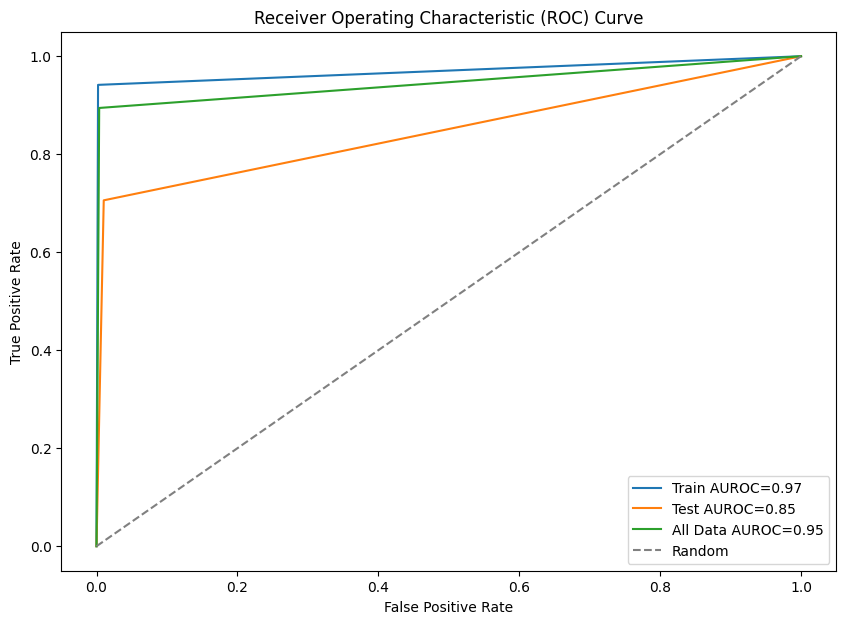

In [54]:
### ASSESS MODEL PERFORMANCE ###

# Predict labels for train, test, and all data
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
all_data_pred = xgb_model.predict(X)

# Balanced Accuracy
y_train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
y_test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
all_data_accuracy = balanced_accuracy_score(Y, all_data_pred)

# F1 Score
y_train_f1 = f1_score(y_train, y_train_pred)
y_test_f1 = f1_score(y_test, y_test_pred)
all_data_f1 = f1_score(Y, all_data_pred)

# Precision
y_train_precision = precision_score(y_train, y_train_pred)
y_test_precision = precision_score(y_test, y_test_pred)
all_data_precision = precision_score(Y, all_data_pred)

# Recall
y_train_recall = recall_score(y_train, y_train_pred)
y_test_recall = recall_score(y_test, y_test_pred)
all_data_recall = recall_score(Y, all_data_pred)

# AUROC
y_train_auroc = roc_auc_score(y_train, y_train_pred)
y_test_auroc = roc_auc_score(y_test, y_test_pred)
all_data_auroc = roc_auc_score(Y, all_data_pred)

# AUC-PR (Area Under the Precision-Recall Curve)
y_train_p, y_train_r, _ = precision_recall_curve(y_train, y_train_pred)
y_test_p, y_test_r, _ = precision_recall_curve(y_test, y_test_pred)
all_data_p, all_data_r, _ = precision_recall_curve(Y, all_data_pred)

y_train_auc_pr = auc(y_train_r, y_train_p)
y_test_auc_pr = auc(y_test_r, y_test_p)
all_data_auc_pr = auc(all_data_r, all_data_p)

# Average Precision Score (APS)
y_train_aps = average_precision_score(y_train, y_train_pred)
y_test_aps = average_precision_score(y_test, y_test_pred)
all_data_aps = average_precision_score(Y, all_data_pred)

# Print Metrics
print(
    f"Balanced Accuracy\nTrain: {y_train_accuracy:.5f}  |  Test: {y_test_accuracy:.5f}  |  All Data: {all_data_accuracy:.5f}\n"
)
print(
    f"F1 Score\nTrain: {y_train_f1:.5f}  |  Test: {y_test_f1:.5f}  |  All Data: {all_data_f1:.5f}\n"
)
print(
    f"Precision\nTrain: {y_train_precision:.5f}  |  Test: {y_test_precision:.5f}  |  All Data: {all_data_precision:.5f}\n"
)
print(
    f"Recall\nTrain: {y_train_recall:.5f}  |  Test: {y_test_recall:.5f}  |  All Data: {all_data_recall:.5f}\n"
)
print(
    f"AUROC\nTrain: {y_train_auroc:.5f}  |  Test: {y_test_auroc:.5f}  |  All Data: {all_data_auroc:.5f}\n"
)
print(
    f"AUC-PR\nTrain: {y_train_auc_pr:.5f}  |  Test: {y_test_auc_pr:.5f}  |  All Data: {all_data_auc_pr:.5f}\n"
)
print(
    f"Average Precision Score\nTrain: {y_train_aps:.5f}  |  Test: {y_test_aps:.5f}  |  All Data: {all_data_aps:.5f}\n"
)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
fpr_all_data, tpr_all_data, _ = roc_curve(Y, all_data_pred)

# Plot Information
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f"Train AUROC={y_train_auroc:.2f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUROC={y_test_auroc:.2f}")
plt.plot(fpr_all_data, tpr_all_data, label=f"All Data AUROC={all_data_auroc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

In [52]:
### Assess which features are the most important

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a list of tuples (feature, importance) and sort it by importance in descending order
sorted_importances = sorted(zip(selected_features, feature_importances), key=lambda x: x[1], reverse=True)

# Display the top 10 most important features
top_features = sorted_importances[:10]
for feature, importance in top_features:
    print(f"{feature}: {importance}")

6494: 0.06664857268333435
6587: 0.06588395684957504
8588: 0.02828303351998329
5760: 0.02095182053744793
670: 0.016430707648396492
19023: 0.016333943232893944
6500: 0.015937646850943565
18472: 0.011945229955017567
1845: 0.010917418636381626
4720: 0.009861569851636887


In [ ]:
### SCRIPT FOR K-FOLD VALIDATION ###
N_FOLDS = 10

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precisions = []
recalls = []
aurocs = []
auc_prs = []
average_precision_scores = []

# Perform k-fold cross-validation
for train_index, test_index in tqdm(
    stratified_kfold.split(X, Y), desc=f"{N_FOLDS}-Fold Validation", unit=" Model(s)"
):
    # Get the relevant train and test data
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = Y[train_index], Y[test_index]

    # Create a new XGBoost model for each fold
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=23)

    # Train the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = xgb_model.predict(X_test_fold)

    # Calculate performance metrics
    accuracy_fold = balanced_accuracy_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold)
    recall_fold = recall_score(y_test_fold, y_pred_fold)
    auroc_fold = roc_auc_score(y_test_fold, y_pred_fold)
    p_fold, r_fold, _ = precision_recall_curve(y_test_fold, y_pred_fold)
    auc_pr_fold = auc(r_fold, p_fold)
    average_precision_score_fold = average_precision_score(y_test_fold, y_pred_fold)

    # Append metrics to lists
    accuracy_scores.append(accuracy_fold)
    f1_scores.append(f1_fold)
    precisions.append(precision_fold)
    recalls.append(recall_fold)
    aurocs.append(auroc_fold)
    auc_prs.append(auc_pr_fold)
    average_precision_scores.append(average_precision_score_fold)

# Print average metrics across all folds
print(f"Average Balanced Accuracy: {sum(accuracy_scores) / N_FOLDS:.5f}")
print(f"Average F1 Score: {sum(f1_scores) / N_FOLDS:.5f}")
print(f"Average Precision: {sum(precisions) / N_FOLDS:.5f}")
print(f"Average Recall: {sum(recalls) / N_FOLDS:.5f}")
print(f"Average AUROC: {sum(aurocs) / N_FOLDS:.5f}")
print(f"Average AUC-PR: {sum(auc_prs) / N_FOLDS:.5f}")
print(f"Average Precision Score: {sum(average_precision_scores) / N_FOLDS:.5f}")